# Skin Moles Classification - Basic CNN (Kaggle Notebook)

This notebook is a **starter template** for training a simple CNN using an image classification dataset in Kaggle.

1. Add your dataset in the right panel (**Add data**)
2. Update `DATASET_DIR` and (if needed) `TRAIN_SUBDIR` / `VAL_SUBDIR`
3. Run all cells


In [1]:
# Core imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)
SEED = 42
tf.keras.utils.set_random_seed(SEED)


2026-02-13 17:03:57.106156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771002237.300374      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771002237.353794      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771002237.830160      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771002237.830208      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771002237.830211      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0


In [2]:
DATASET_DIR = "/kaggle/input/datasets/adisongoh/skin-moles-benign-vs-malignant-melanoma-isic19"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 150
VALIDATION_SPLIT = 0.2  # only used when VAL_SUBDIR is None

print('Using dataset directory:', DATASET_DIR)


Using dataset directory: /kaggle/input/datasets/adisongoh/skin-moles-benign-vs-malignant-melanoma-isic19


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_DIR,
        validation_split=VALIDATION_SPLIT,
        subset='training',
        label_mode='int',
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_DIR,
        validation_split=VALIDATION_SPLIT,
        subset='validation',
        label_mode='int',
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )

class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes:', class_names)
print('Number of classes:', num_classes)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


Found 9522 files belonging to 2 classes.
Using 7618 files for training.


I0000 00:00:1771002258.921719      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 9522 files belonging to 2 classes.
Using 1904 files for validation.
Classes: ['label_MEL', 'label_NV']
Number of classes: 2


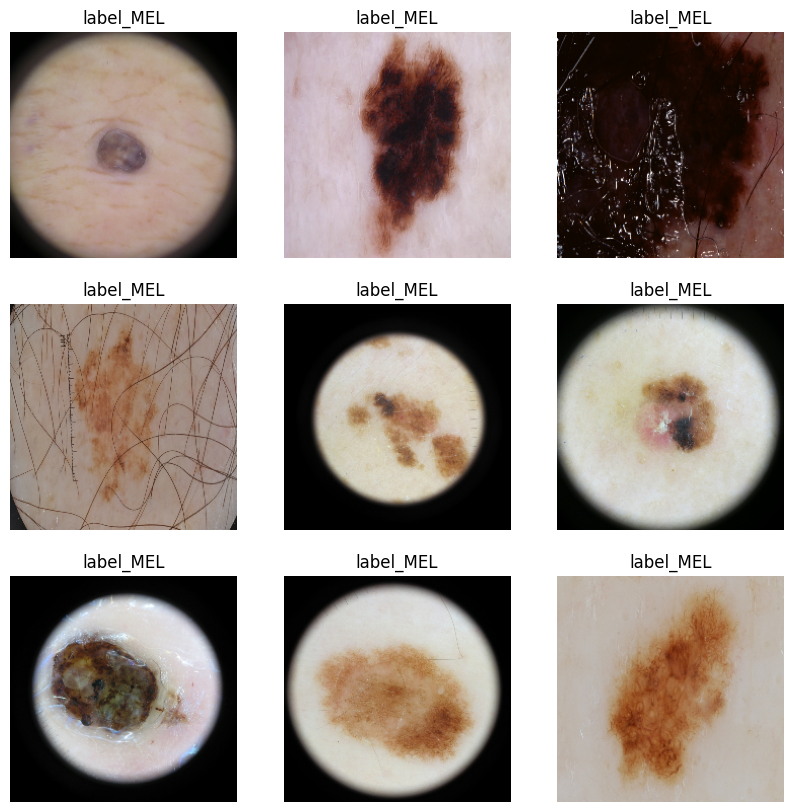

In [4]:
# Quick sanity-check visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis('off')
plt.show()


In [5]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMAGE_SIZE + (3,)
)
base.trainable = False

inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# Training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/150


I0000 00:00:1771002316.807386      70 service.cc:152] XLA service 0x7ddc50211d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771002316.807425      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771002319.288187      70 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771002331.217928      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


239/239 ━━━━━━━━━━━━━━━━━━━━ 67s 171ms/step - accuracy: 0.6685 - auc: 0.7394 - loss: 0.5857 - val_accuracy: 0.7679 - val_auc: 0.8608 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 2/150
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7659 - auc: 0.8575 - loss: 0.4693 - val_accuracy: 0.7831 - val_auc: 0.8728 - val_loss: 0.4457 - learning_rate: 0.0010
Epoch 3/150
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7817 - auc: 0.8709 - loss: 0.4441 - val_accuracy: 0.7815 - val_auc: 0.8773 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 4/150
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7869 - auc: 0.8752 - loss: 0.4394 - val_accuracy: 0.7826 - val_auc: 0.8806 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 5/150
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7907 - auc: 0.8812 - loss: 0.4278 - val_accuracy: 0.7883 - val_auc: 0.8813 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 6/150
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7942 - auc: 

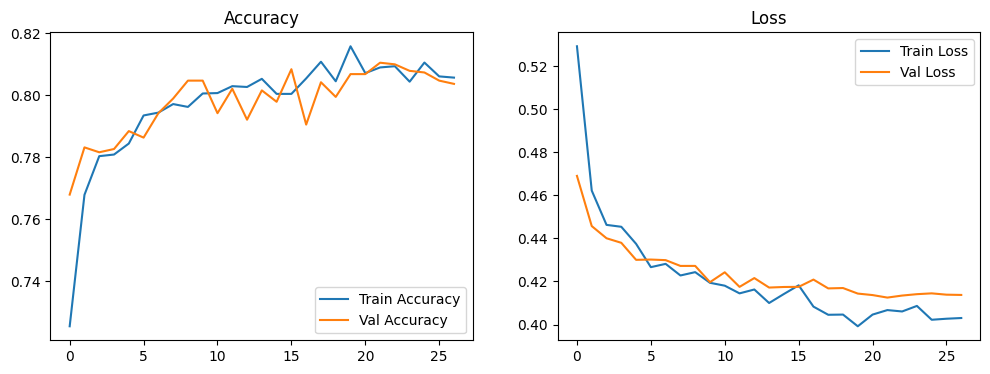

In [7]:
# Plot train/validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()


In [8]:
# Save model artifact in Kaggle working directory
save_path = '/kaggle/working/skin_mole_cnn.keras'
model.save(save_path)
print('Model saved to:', save_path)


Model saved to: /kaggle/working/skin_mole_cnn.keras
